#**Osservazioni sulle vendite settimanali di prodotti dei settori Calcio, Pesca e Casual**



In [1]:
#https://github.com/TommasoStrada/Progetto-Data-Science-Lab

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

In [2]:
#!pip install xgboost 1.6

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost

In [4]:
shift_settimanale = 1
shift_mensile = 4        #stessa settimana circa mese precedente
shift_annuale = 52       #stesso settimana, circa anno precedente
shift_scelto = shift_settimanale

In [5]:
repo_alessandro_calcio = "https://github.com/Alessandro-Fasani/DsLab/raw/main/calcio_settimanale.csv"
repo_alessandro_pesca = "https://github.com/Alessandro-Fasani/DsLab/raw/main/pesca_settimanale.csv"
repo_alessandro_casual = "https://github.com/Alessandro-Fasani/DsLab/raw/main/casual_settimanale.csv"

repo_team_calcio = ""
repo_team_pesca = ""
repo_team_casual = ""

In [6]:
ds_calcio = pd.read_csv(repo_alessandro_calcio)
ds_pesca = pd.read_csv(repo_alessandro_pesca)
ds_casual = pd.read_csv(repo_alessandro_casual)

In [7]:
ds_calcio['year'] = pd.to_datetime(ds_calcio['year'])
ds_calcio = ds_calcio[ds_calcio["year"] <= "2021-12-31" ]

ds_pesca['year'] = pd.to_datetime(ds_pesca['year'])
ds_pesca = ds_pesca[ds_pesca["year"] <= "2021-12-31" ]

ds_casual['year'] = pd.to_datetime(ds_casual['year'])
ds_casual = ds_casual[ds_casual["year"] <= "2021-12-31" ]
ds_casual
#ds_casual.dtypes

,Unnamed: 0,year,revenue
0,0,2014-01-05,0.00
1,1,2014-01-12,0.00
2,2,2014-01-19,4762.11
3,3,2014-01-26,0.00
4,4,2014-02-02,2101.33
...,...,...,...
412,412,2021-11-28,139666.95
413,413,2021-12-05,46987.92
414,414,2021-12-12,77640.87
415,415,2021-12-19,64517.93


In [8]:
porzione_test = round(len(ds_calcio) * 0.2)       # 20% circa verra usato per il test 

In [9]:
print("xgboost versione numero: ", xgboost.__version__)

xgboost versione numero:  0.90


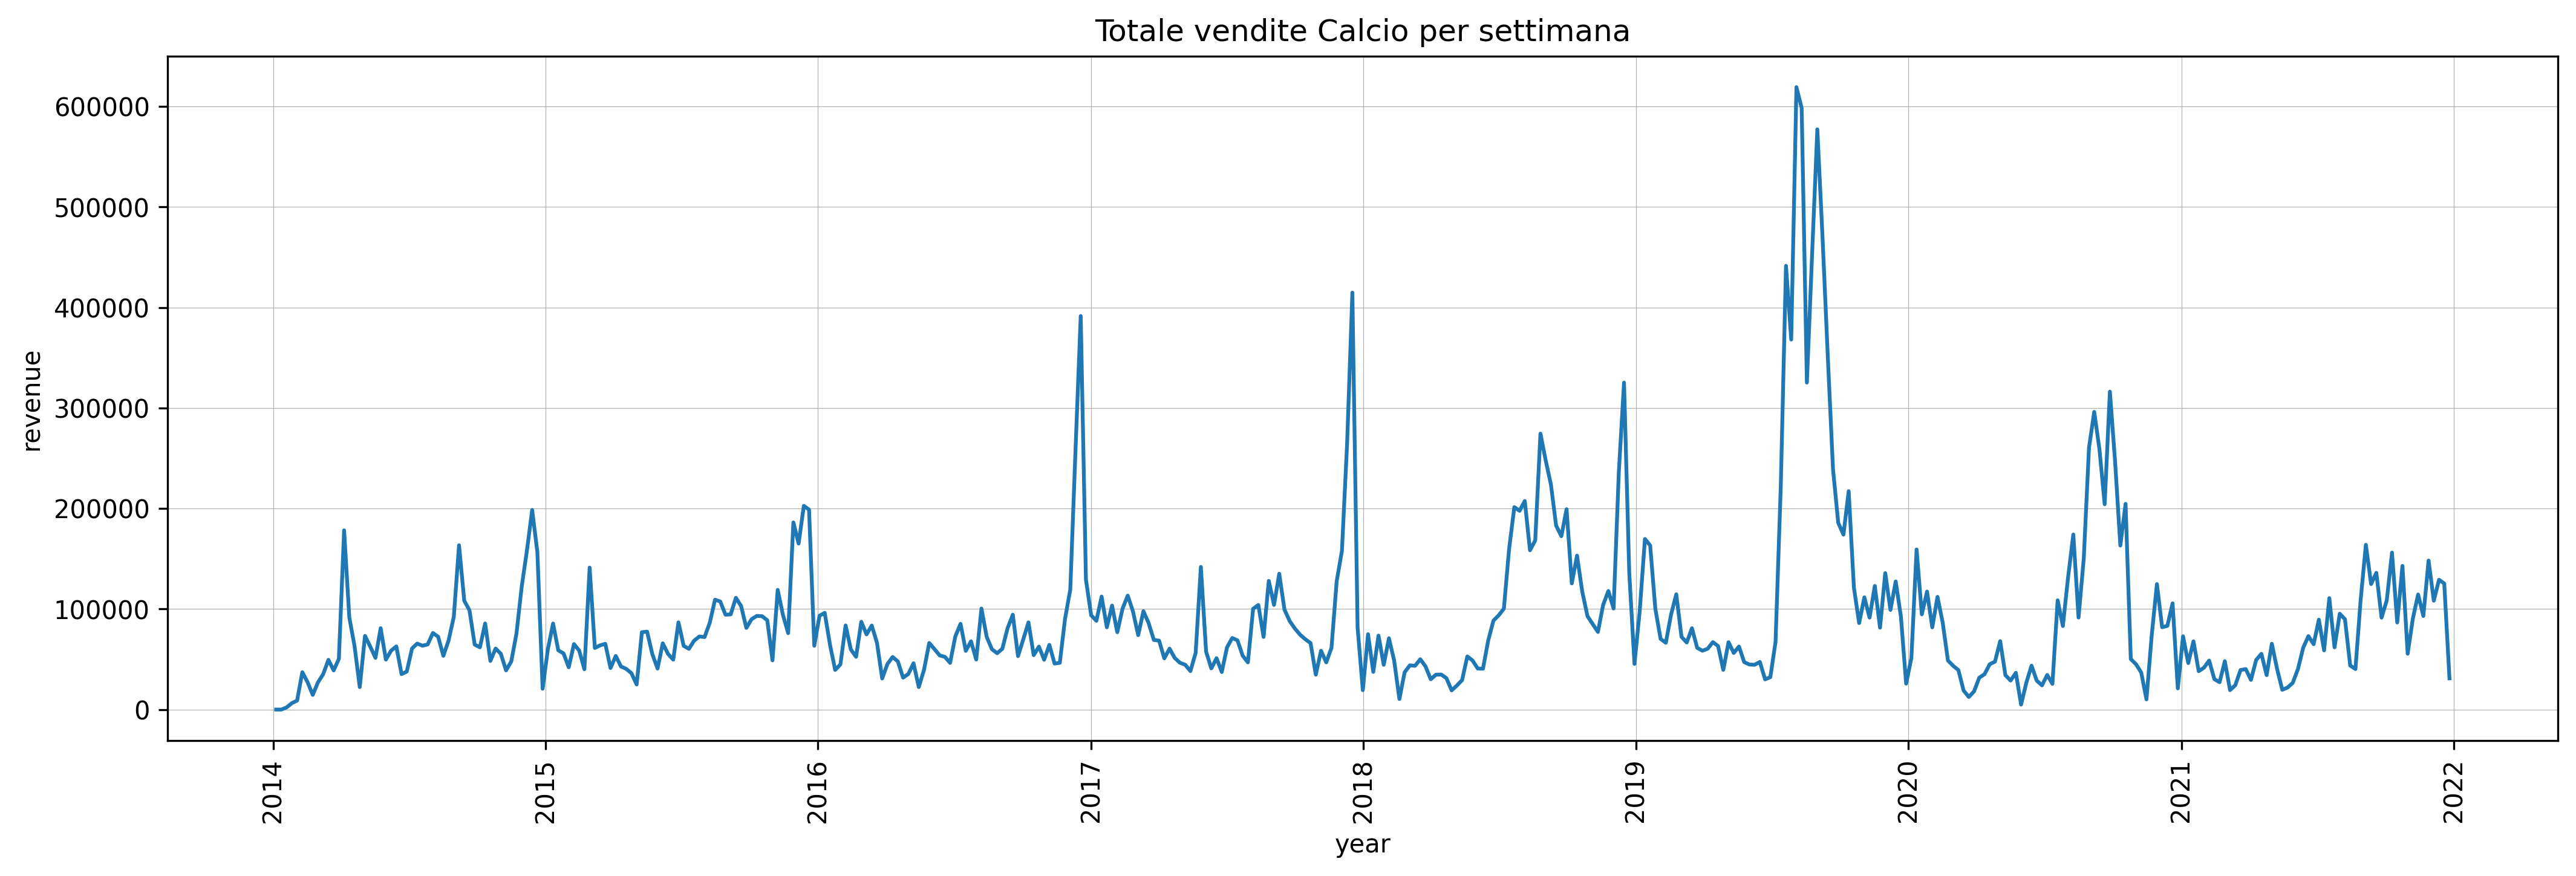

In [10]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
plt.title("Totale vendite Calcio per settimana")
ax.tick_params(axis='x', rotation=90)

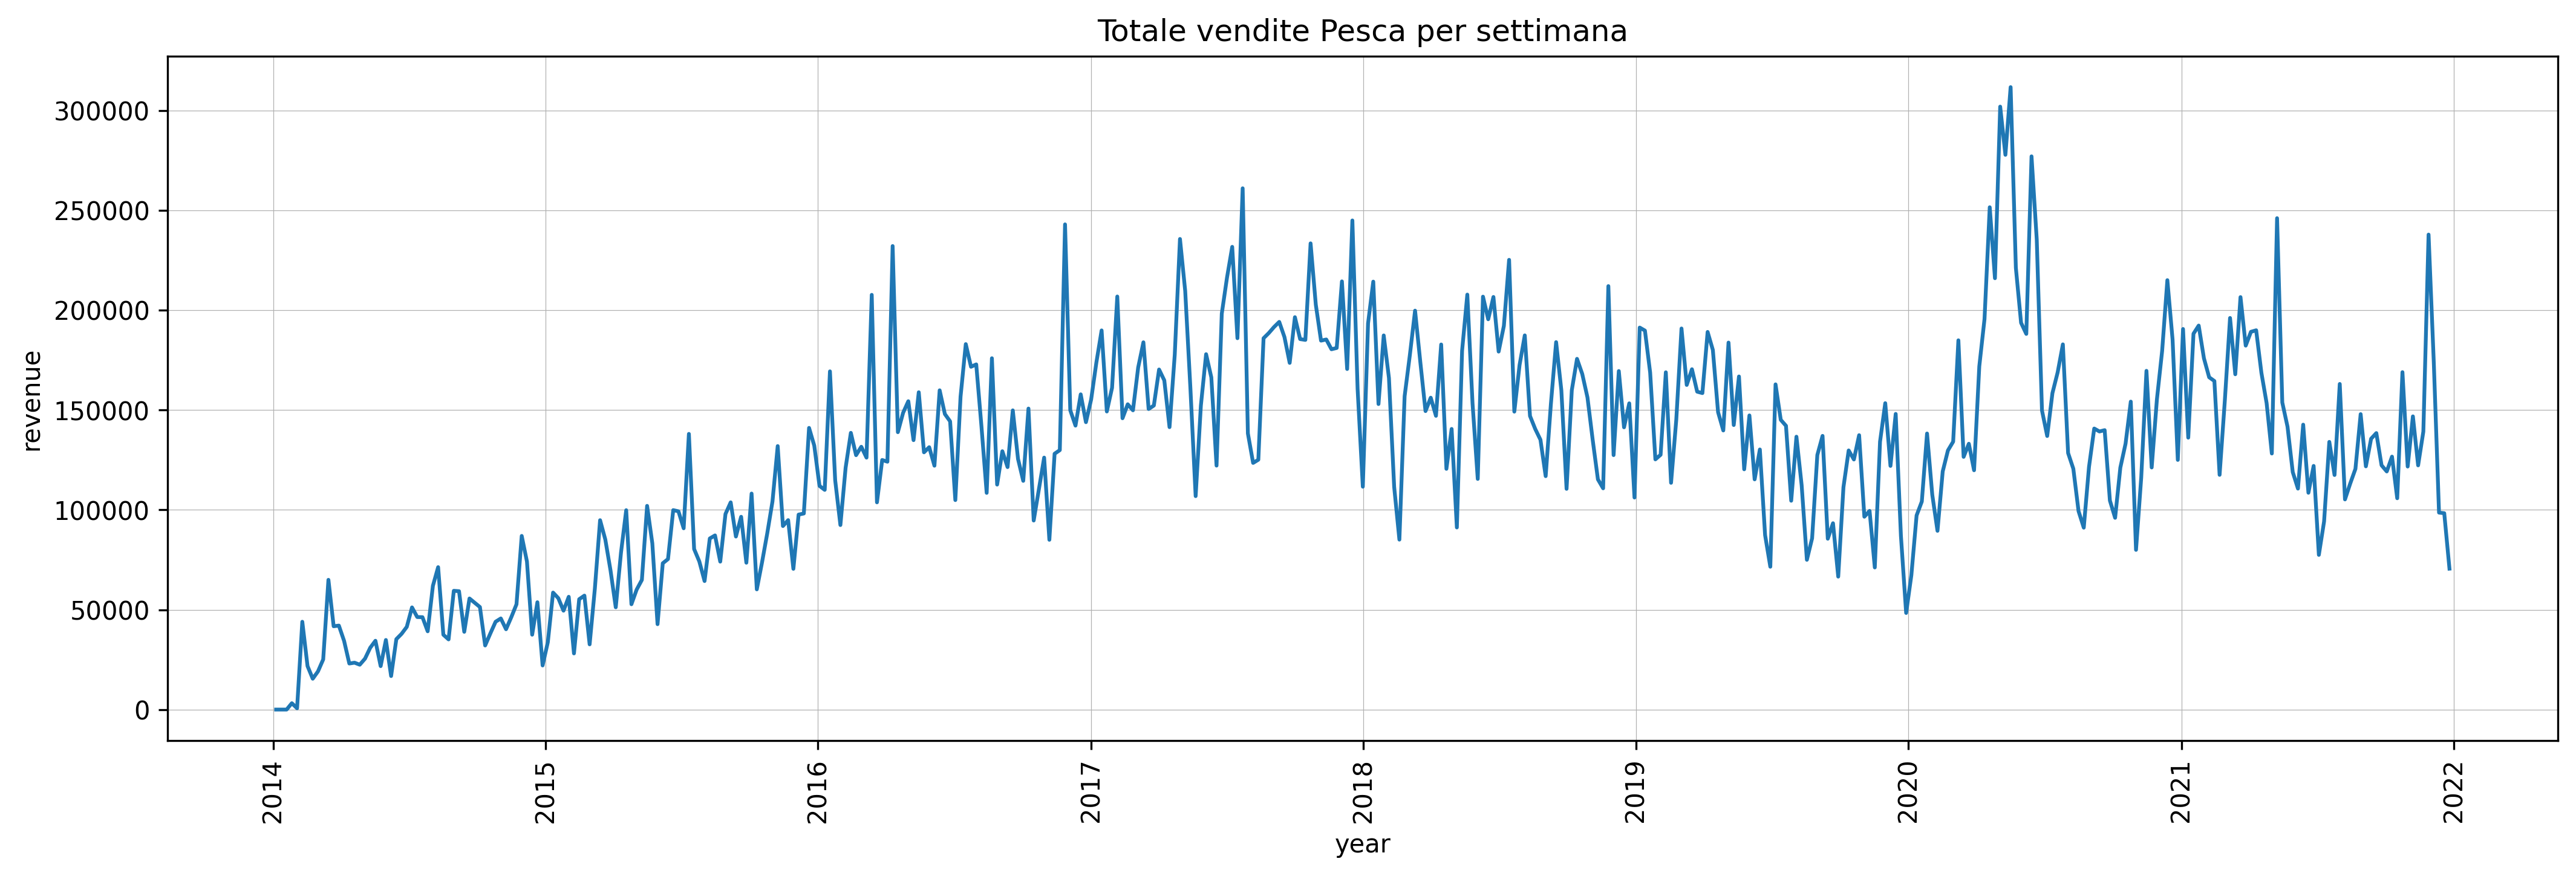

In [11]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
plt.title("Totale vendite Pesca per settimana")
ax.tick_params(axis='x', rotation=90)

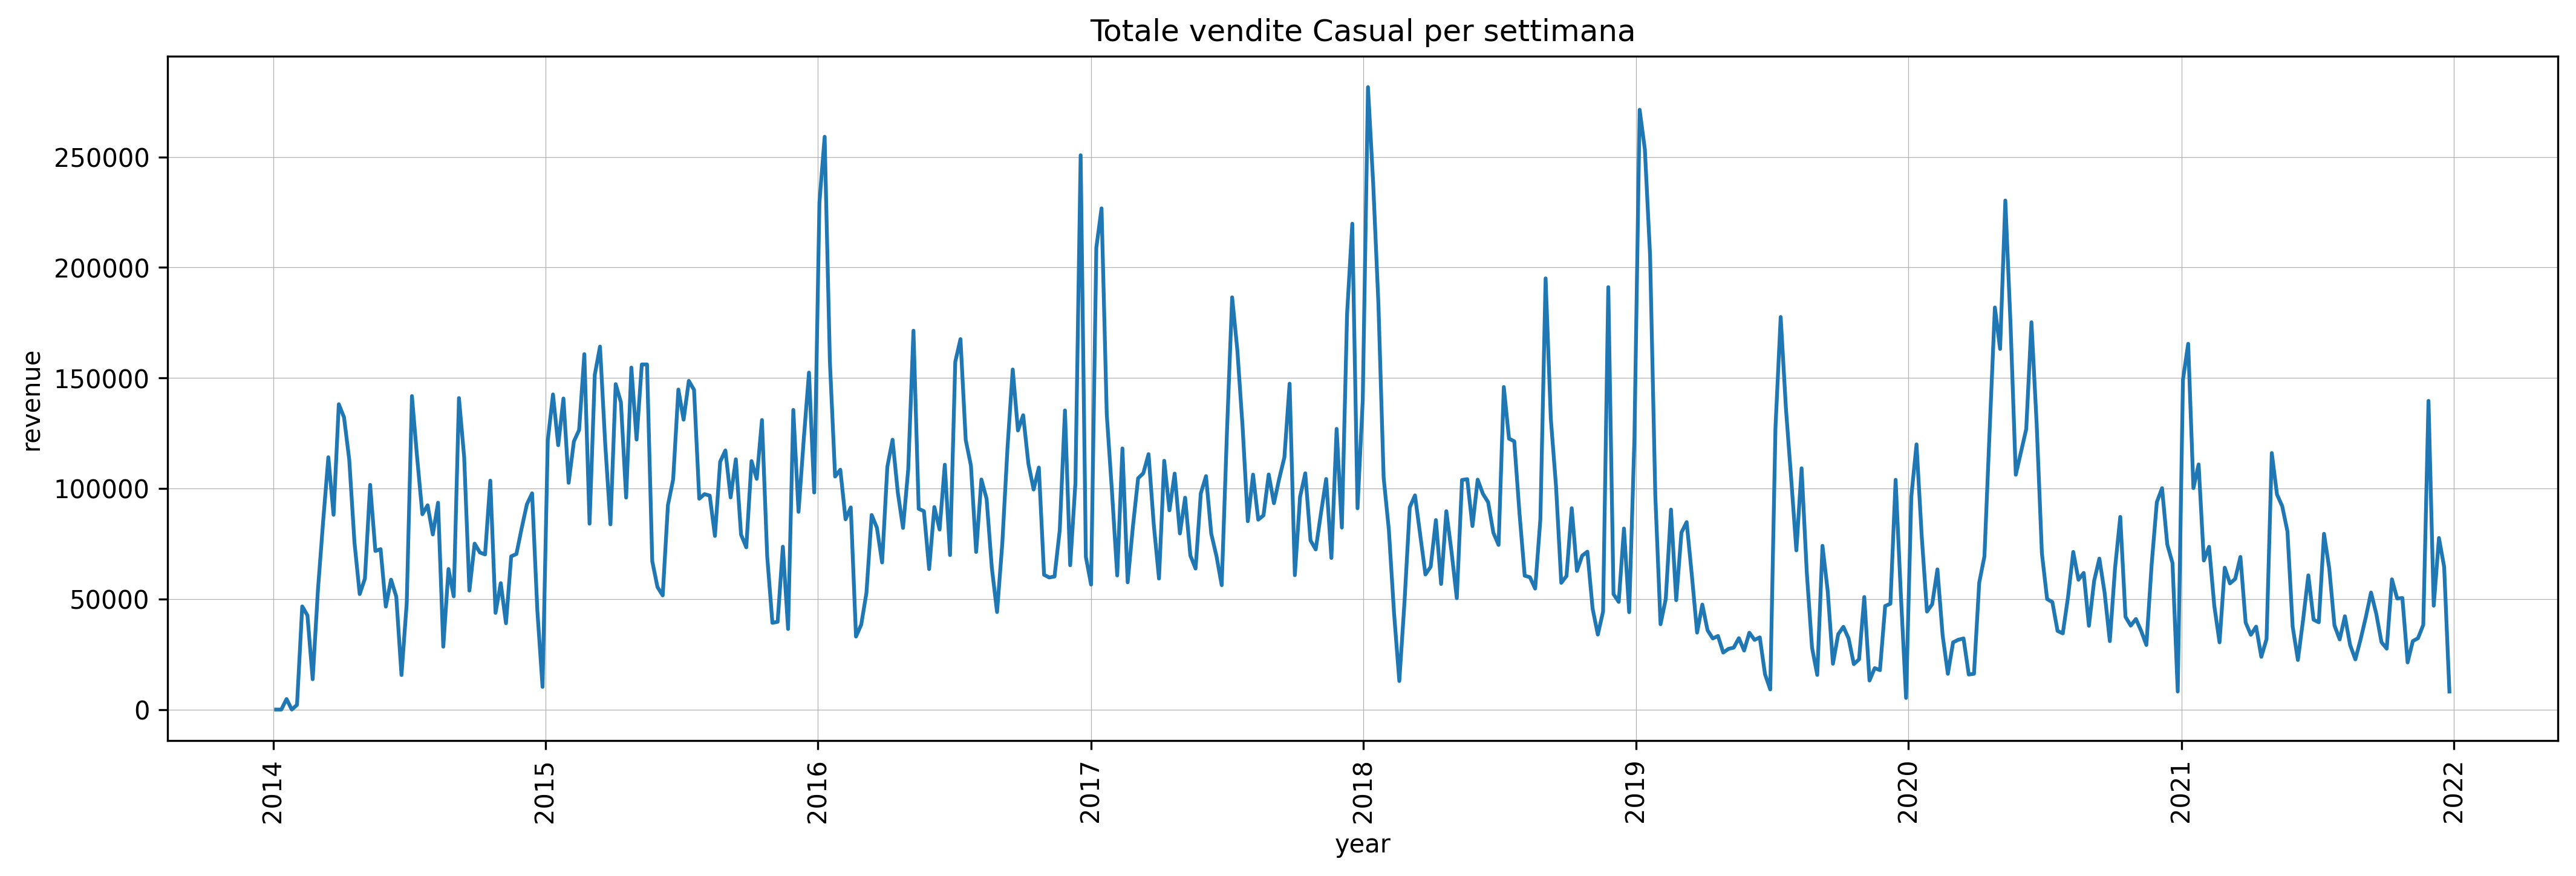

In [12]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x='year',  y='revenue')
plt.title("Totale vendite Casual per settimana")
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [13]:
ds_calcio["totale_periodo_prec"] = ds_calcio["revenue"].shift(+shift_scelto)
ds_pesca["totale_periodo_prec"] = ds_pesca["revenue"].shift(+shift_scelto)
ds_casual["totale_periodo_prec"] = ds_casual["revenue"].shift(+shift_scelto)


ds_calcio= ds_calcio.dropna()  
ds_pesca= ds_pesca.dropna()    
ds_casual= ds_casual.dropna()


print(ds_calcio.shape)
print(ds_pesca.shape)
print(ds_casual.shape)

(416, 4)
(416, 4)
(416, 4)


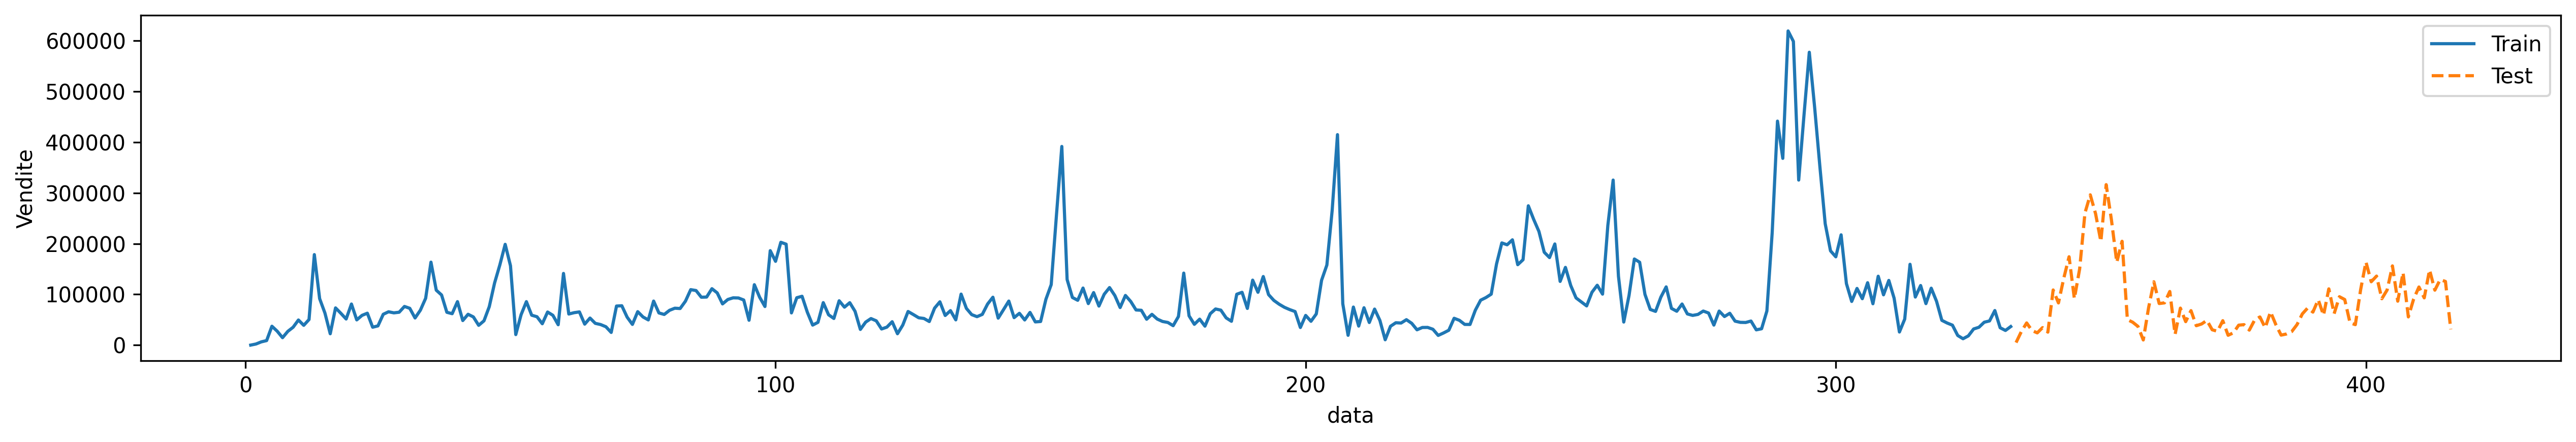

In [14]:
#LIST INPUT, divisione tra parte train e parte dedicata al test
x_calcio = ds_calcio[['totale_periodo_prec']]
x_pesca = ds_pesca[['totale_periodo_prec']]
x_casual = ds_casual[['totale_periodo_prec']]

x_calcio_to_train = x_calcio.iloc[:(len(x_calcio)-porzione_test)]
x_pesca_to_train = x_pesca.iloc[:(len(x_pesca)-porzione_test)]
x_casual_to_train = x_casual.iloc[:(len(x_casual)-porzione_test)]


x_calcio_to_test = x_calcio.iloc[(len(x_calcio)-porzione_test):]
x_pesca_to_test = x_pesca.iloc[(len(x_pesca)-porzione_test):]
x_casual_to_test = x_casual.iloc[(len(x_casual)-porzione_test):]


#LIST OUTPUT, divisione tra parte train e parte dedicata al test
y_calcio = ds_calcio[['revenue']]
y_pesca = ds_pesca[['revenue']]
y_casual = ds_casual[['revenue']]

y_calcio_to_train = y_calcio.iloc[:(len(y_calcio)-porzione_test)]
y_pesca_to_train = y_pesca.iloc[:(len(y_pesca)-porzione_test)]
y_casual_to_train = y_casual.iloc[:(len(y_casual)-porzione_test)]


y_calcio_to_test = y_calcio.iloc[(len(y_calcio)-porzione_test):]
y_pesca_to_test = y_pesca.iloc[(len(y_pesca)-porzione_test):]
y_casual_to_test = y_casual.iloc[(len(y_casual)-porzione_test):]


fig, ax = plt.subplots(figsize=(17, 3))
ax.plot(y_calcio_to_train, ls='-', label='Train')
ax.plot(y_calcio_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
estimator_calcio = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.01)
estimator_pesca = XGBRegressor(objective='reg:squarederror', n_estimators=250, learning_rate=0.01)
estimator_casual = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.01)

estimator_calcio.fit(x_calcio_to_train, y_calcio_to_train,
              eval_set=[(x_calcio_to_train, y_calcio_to_train), (x_calcio_to_test, y_calcio_to_test)],
              eval_metric='mae')

estimator_pesca.fit(x_pesca_to_train, y_pesca_to_train,
              eval_set=[(x_pesca_to_train, y_pesca_to_train), (x_pesca_to_test, y_pesca_to_test)],
              eval_metric='mae')

estimator_casual.fit(x_casual_to_train, y_casual_to_train,
              eval_set=[(x_casual_to_train, y_casual_to_train), (x_casual_to_test, y_casual_to_test)],
              eval_metric='mae')

[0]	validation_0-mae:92040.6	validation_1-mae:86372
[1]	validation_0-mae:91142.6	validation_1-mae:85485.3
[2]	validation_0-mae:90254.5	validation_1-mae:84617.6
[3]	validation_0-mae:89374.1	validation_1-mae:83748.3
[4]	validation_0-mae:88503.3	validation_1-mae:82897.5
[5]	validation_0-mae:87640.6	validation_1-mae:82045.2
[6]	validation_0-mae:86788	validation_1-mae:81199.7
[7]	validation_0-mae:85945.1	validation_1-mae:80373.9
[8]	validation_0-mae:85108.8	validation_1-mae:79546.3
[9]	validation_0-mae:84280.9	validation_1-mae:78725.5
[10]	validation_0-mae:83462.5	validation_1-mae:77923.8
[11]	validation_0-mae:82650.4	validation_1-mae:77120.4
[12]	validation_0-mae:81847.9	validation_1-mae:76334.3
[13]	validation_0-mae:81051.6	validation_1-mae:75551.4
[14]	validation_0-mae:80263.2	validation_1-mae:74778.6
[15]	validation_0-mae:79485.2	validation_1-mae:74003.5
[16]	validation_0-mae:78712.4	validation_1-mae:73245.2
[17]	validation_0-mae:77951.5	validation_1-mae:72485.1
[18]	validation_0-mae:77

XGBRegressor(learning_rate=0.01, objective='reg:squarederror')

In [16]:
predictions_calcio = estimator_calcio.predict(x_calcio_to_test)
predictions_pesca = estimator_pesca.predict(x_pesca_to_test)
predictions_casual = estimator_casual.predict(x_casual_to_test)

#ds_calcio_annuale = ds_calcio_annuale.reset_index().drop('index', axis=1)  #non posso usarli perchè me li aggiunge all'inizio del dataset
#ds_calcio_annuale['predictions'] = pd.Series(predictions)

#plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
#fig, ax = plt.subplots()
#sns.lineplot(data=ds_calcio_annuale, x= "year", y='revenue')
#sns.lineplot(data=ds_calcio_annuale, x='year', y='predictions', palette= "red")
#plt.grid(linestyle='-', linewidth=0.3)
#ax.tick_params(axis='x', rotation=90)

In [17]:
calcio_evalutation_ds = ds_calcio[(len(ds_calcio)-porzione_test):]   
calcio_evalutation_ds = calcio_evalutation_ds.reset_index().drop('index', axis=1)
calcio_evalutation_ds['predictions'] = pd.Series(predictions_calcio)
calcio_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,4955.87,36535.04,28748.408203
1,335,2020-06-07,26636.94,4955.87,21116.250000
2,336,2020-06-14,43676.55,26636.94,28748.408203
3,337,2020-06-21,28738.55,43676.55,36098.132812
4,338,2020-06-28,24092.69,28738.55,28748.408203
...,...,...,...,...,...
78,412,2021-11-28,148271.49,93084.28,56430.261719
79,413,2021-12-05,108278.81,148271.49,63752.945312
80,414,2021-12-12,129102.44,108278.81,63752.945312
81,415,2021-12-19,125427.83,129102.44,63752.945312


In [18]:
pesca_evalutation_ds = ds_pesca[(len(ds_pesca)-porzione_test):]  
pesca_evalutation_ds = pesca_evalutation_ds.reset_index().drop('index', axis=1)
pesca_evalutation_ds['predictions'] = pd.Series(predictions_pesca)
pesca_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,193686.95,221261.05,166430.265625
1,335,2020-06-07,188135.90,193686.95,165848.750000
2,336,2020-06-14,277074.28,188135.90,165848.750000
3,337,2020-06-21,235418.00,277074.28,225906.234375
4,338,2020-06-28,149833.56,235418.00,166430.265625
...,...,...,...,...,...
78,412,2021-11-28,237888.83,139230.84,126051.085938
79,413,2021-12-05,173790.36,237888.83,166430.265625
80,414,2021-12-12,98639.43,173790.36,161747.015625
81,415,2021-12-19,98343.61,98639.43,92516.617188


In [19]:
casual_evalutation_ds = ds_casual[(len(ds_casual)-porzione_test):]  
casual_evalutation_ds = casual_evalutation_ds.reset_index().drop('index', axis=1)
casual_evalutation_ds['predictions'] = pd.Series(predictions_casual)
casual_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,116597.62,106232.06,59949.992188
1,335,2020-06-07,126904.24,116597.62,59949.992188
2,336,2020-06-14,175230.72,126904.24,79533.882812
3,337,2020-06-21,129054.13,175230.72,79675.476562
4,338,2020-06-28,70592.41,129054.13,79156.148438
...,...,...,...,...,...
78,412,2021-11-28,139666.95,38335.35,30757.779297
79,413,2021-12-05,46987.92,139666.95,79156.148438
80,414,2021-12-12,77640.87,46987.92,42630.203125
81,415,2021-12-19,64517.93,77640.87,51959.238281


In [20]:
#TROVARE UN VALUTATORE DELLE PERFORMANCE DI FITTING ANALOGO PER L'XGBOOST
#print('Did the model fit?', pd.Series(predictions_calcio).is_fitted) 
#print('AIC', pd.Series(predictions).aic) 
#print(pesca_evalutation_ds.summary())


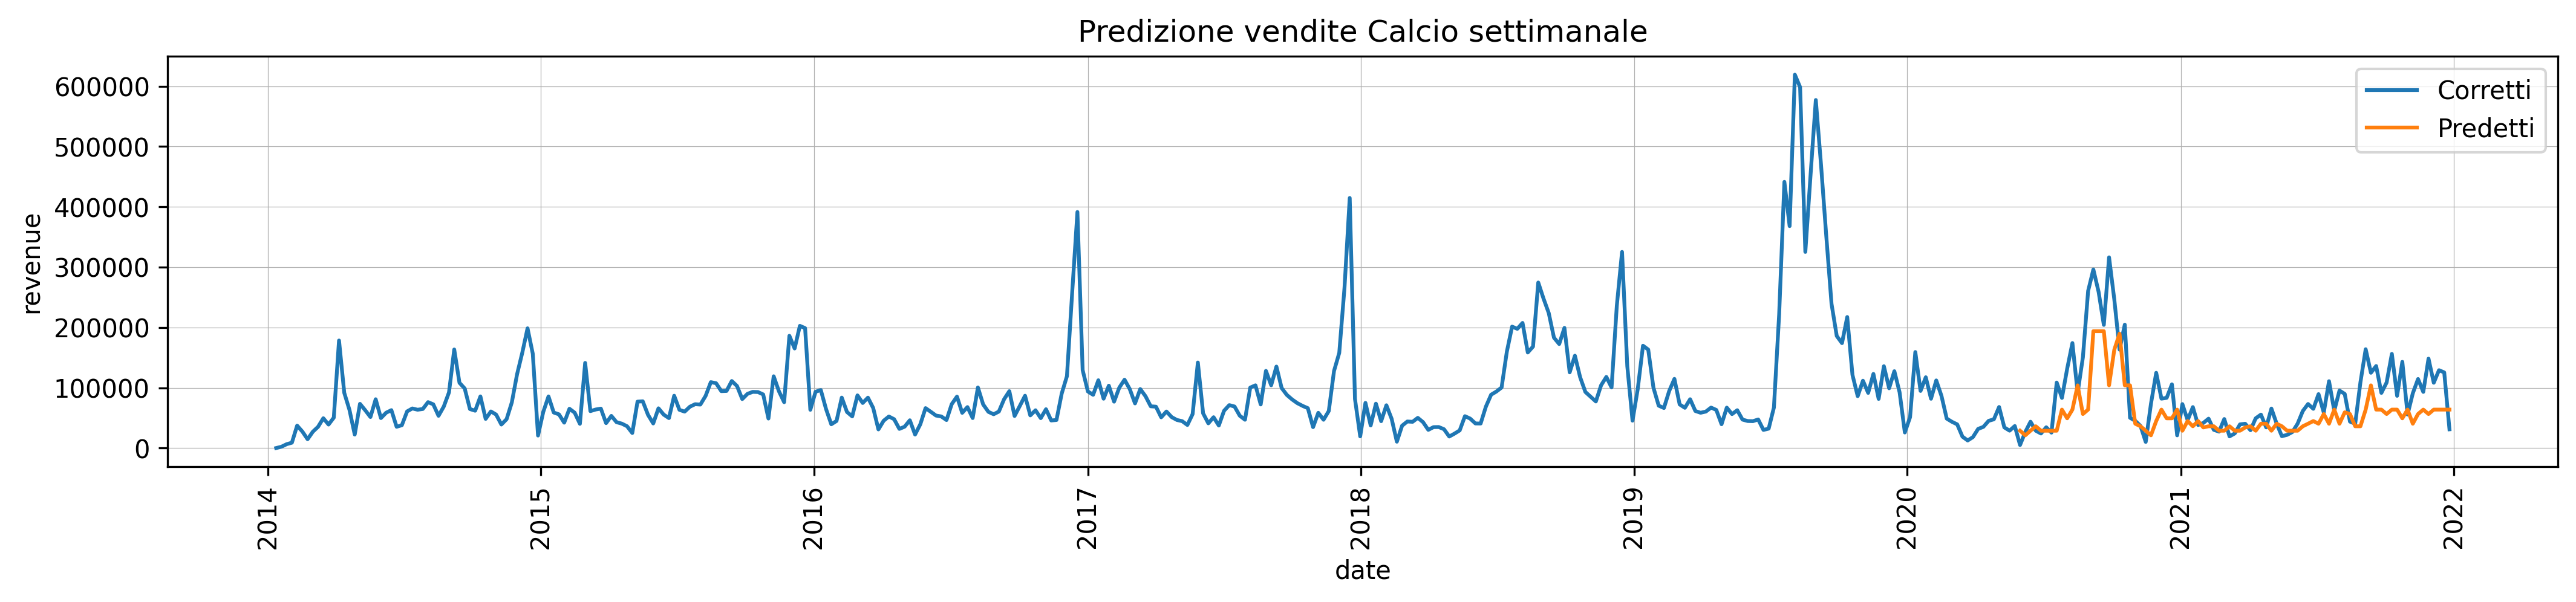

In [21]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x= "year", y='revenue', label= "Corretti" )     #_evalutation
sns.lineplot(data=calcio_evalutation_ds, x='year', y='predictions', palette= "red",  label= "Predetti")

#x = calcio_evalutation_ds['year']  
#y = calcio_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = calcio_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  calcio_evalutation_ds

plt.title("Predizione vendite Calcio settimanale")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

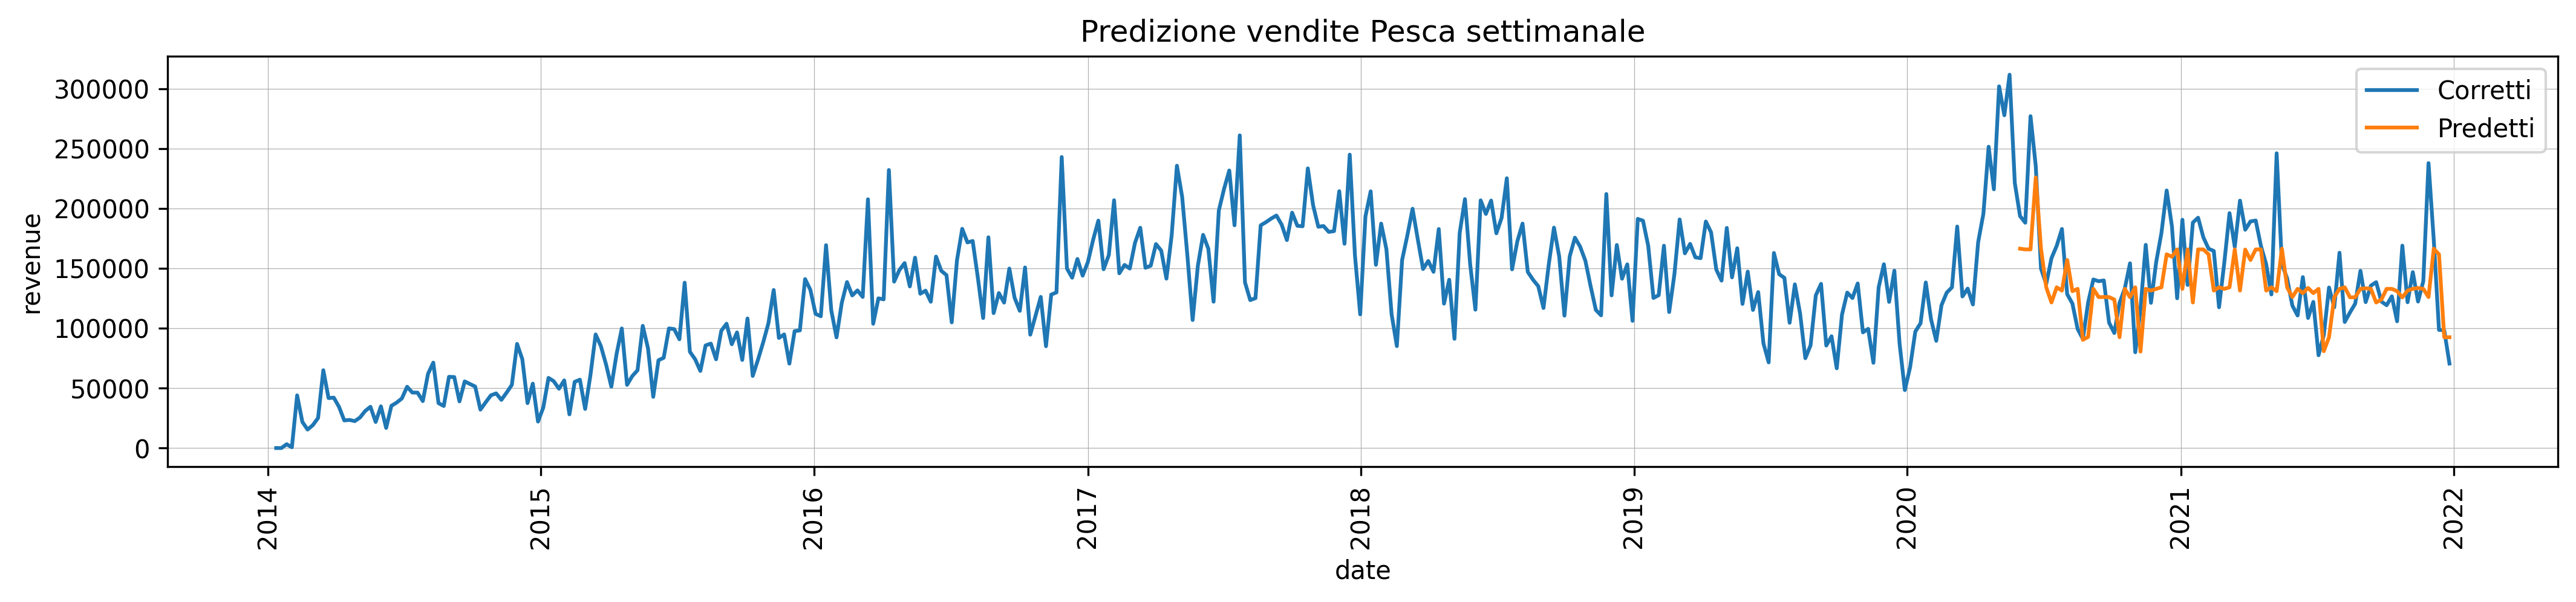

In [22]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=pesca_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = pesca_evalutation_ds['year']  
#y = pesca_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = pesca_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  pesca_evalutation_ds

plt.title("Predizione vendite Pesca settimanale")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

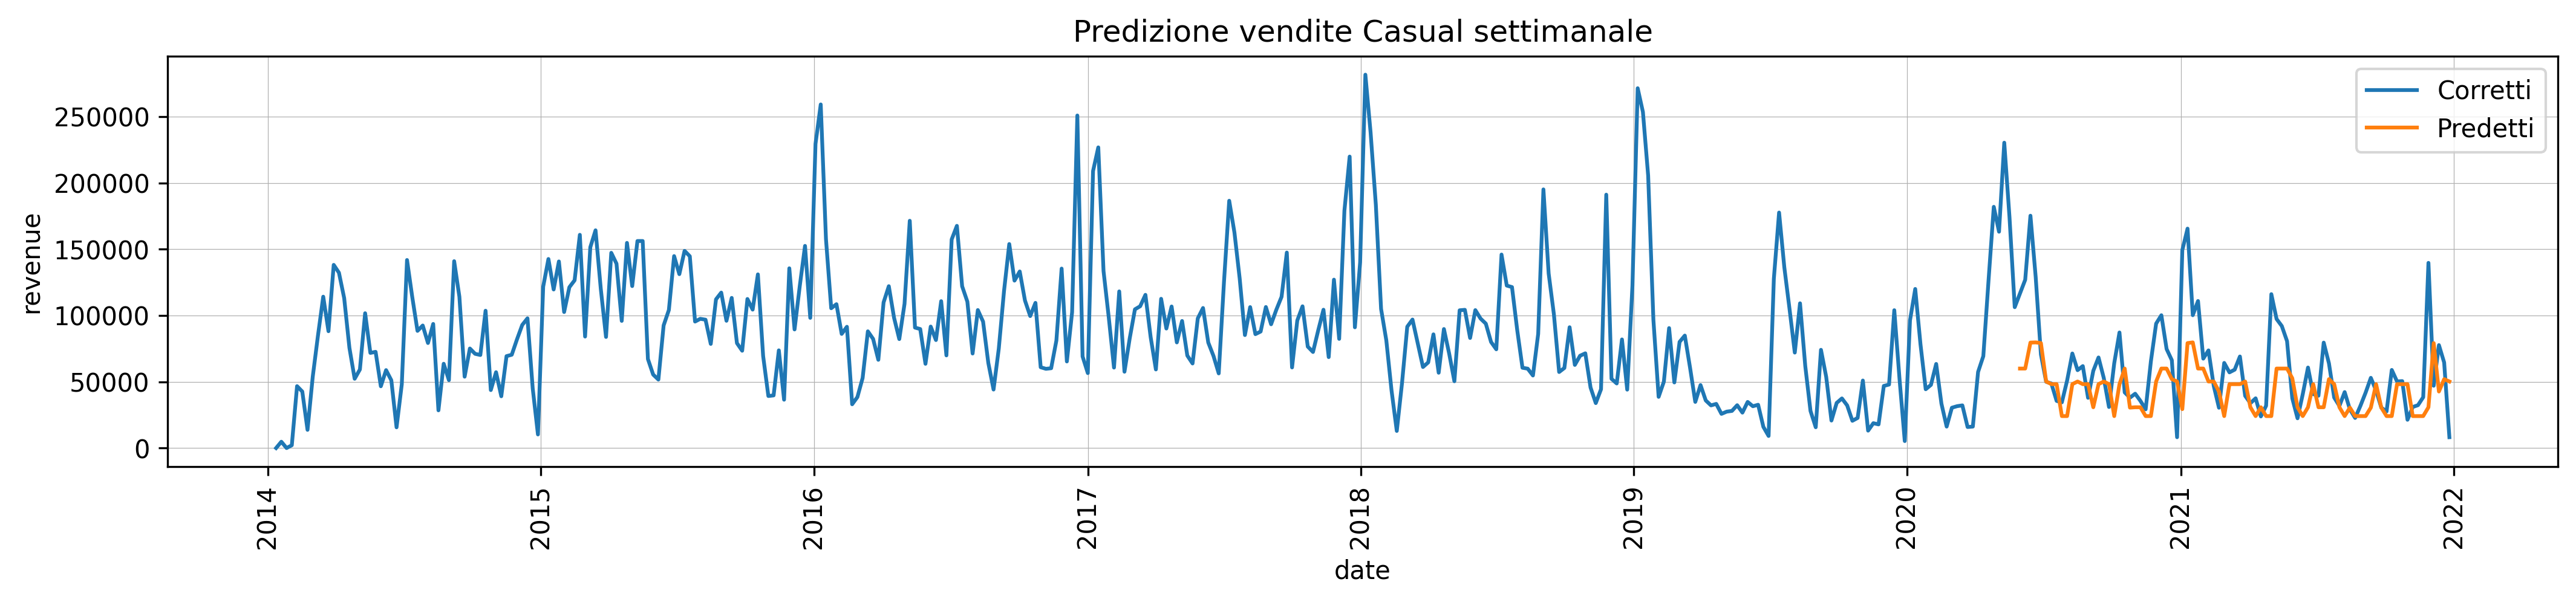

In [23]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=casual_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = casual_evalutation_ds['year']  
#y = casual_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = casual_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  casual_evalutation_ds

plt.title("Predizione vendite Casual settimanale")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [24]:
calcio_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,4955.87,36535.04,28748.408203
1,335,2020-06-07,26636.94,4955.87,21116.250000
2,336,2020-06-14,43676.55,26636.94,28748.408203
3,337,2020-06-21,28738.55,43676.55,36098.132812
4,338,2020-06-28,24092.69,28738.55,28748.408203
...,...,...,...,...,...
78,412,2021-11-28,148271.49,93084.28,56430.261719
79,413,2021-12-05,108278.81,148271.49,63752.945312
80,414,2021-12-12,129102.44,108278.81,63752.945312
81,415,2021-12-19,125427.83,129102.44,63752.945312


In [25]:
pesca_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,193686.95,221261.05,166430.265625
1,335,2020-06-07,188135.90,193686.95,165848.750000
2,336,2020-06-14,277074.28,188135.90,165848.750000
3,337,2020-06-21,235418.00,277074.28,225906.234375
4,338,2020-06-28,149833.56,235418.00,166430.265625
...,...,...,...,...,...
78,412,2021-11-28,237888.83,139230.84,126051.085938
79,413,2021-12-05,173790.36,237888.83,166430.265625
80,414,2021-12-12,98639.43,173790.36,161747.015625
81,415,2021-12-19,98343.61,98639.43,92516.617188


In [26]:
casual_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,334,2020-05-31,116597.62,106232.06,59949.992188
1,335,2020-06-07,126904.24,116597.62,59949.992188
2,336,2020-06-14,175230.72,126904.24,79533.882812
3,337,2020-06-21,129054.13,175230.72,79675.476562
4,338,2020-06-28,70592.41,129054.13,79156.148438
...,...,...,...,...,...
78,412,2021-11-28,139666.95,38335.35,30757.779297
79,413,2021-12-05,46987.92,139666.95,79156.148438
80,414,2021-12-12,77640.87,46987.92,42630.203125
81,415,2021-12-19,64517.93,77640.87,51959.238281


In [27]:
print('Calcio XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(calcio_evalutation_ds["revenue"] - calcio_evalutation_ds["predictions"])))

Calcio XgBoost Mean Absolute Error (MAE):  38746.73099491717


In [28]:
print('Pesca XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(pesca_evalutation_ds["revenue"] - pesca_evalutation_ds["predictions"])))

Pesca XgBoost Mean Absolute Error (MAE):  26312.896265060237


In [29]:
print('Casual XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(casual_evalutation_ds["revenue"] - casual_evalutation_ds["predictions"])))

Casual XgBoost Mean Absolute Error (MAE):  23632.229785391566


In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(calcio_evalutation_ds["revenue"] - calcio_evalutation_ds["predictions"])))/MAEoneWeekCalcio)-1)*100    )

In [32]:
print('Calcio XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(calcio_evalutation_ds["revenue"], calcio_evalutation_ds["predictions"]))

Calcio XgBoost Mean Absolute Percentage Error (MAPE):  47.444406505997534


In [33]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(pesca_evalutation_ds["revenue"] - pesca_evalutation_ds["predictions"])))/MAEoneWeekPesca)-1)*100     )

In [34]:
print('Pesca XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(pesca_evalutation_ds["revenue"], pesca_evalutation_ds["predictions"]))

Pesca XgBoost Mean Absolute Percentage Error (MAPE):  17.856683663224885


In [35]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(casual_evalutation_ds["revenue"] - casual_evalutation_ds["predictions"])))/MAEoneWeekCasual)-1)*100     )

In [36]:
print('Casual XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(casual_evalutation_ds["revenue"], casual_evalutation_ds["predictions"]))

Casual XgBoost Mean Absolute Percentage Error (MAPE):  44.807973868103076


(Calcio migliore intorno ai 100)
(Pesca migliore intorno ai 250)
(Casual migliore intorno ai 100)



Con shift +1 settimana


* Calcio XgBoost Mean Absolute Error (MAE):  38746.73
* Pesca XgBoost Mean Absolute Error (MAE):  26312.90
* Casual XgBoost Mean Absolute Error (MAE):  23632.23


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  47.44 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  17.86 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  44.81 %



Con shift +4 settimane

* Calcio XgBoost Mean Absolute Error (MAE):  49214.45
* Pesca XgBoost Mean Absolute Error (MAE):  30224.57
* Casual XgBoost Mean Absolute Error (MAE):  28442.11


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  71.41 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  21.03 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  63.26 %




Con shift +52 settimane

* Calcio XgBoost Mean Absolute Error (MAE):  44356.58
* Pesca XgBoost Mean Absolute Error (MAE):  32371.68
* Casual XgBoost Mean Absolute Error (MAE):  28953


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  75.03 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  22.53 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  72.26 %